In [55]:
import genome
from genome import Genom, Node
import numpy as np
import operator
import copy
from time import sleep

In [56]:
genom = Genom(2,1)

In [57]:
genom.p_nodes()
genom.p_connections()

===== Input Nodes =====
Key: -2 Type: input Bias: 0
Key: -1 Type: input Bias: 0
===== Hidden Nodes =====
===== Output Nodes =====
Key: 0 Type: out Bias: 0

===== Connections =====
-2 --> 0 Weight: -0.029102512102240588 is active : True
-1 --> 0 Weight: -1.1066724868085145 is active : True



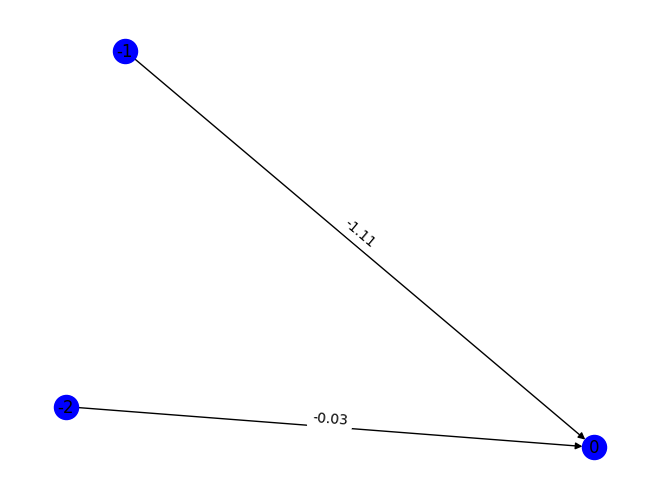

In [58]:
genom.visualize()

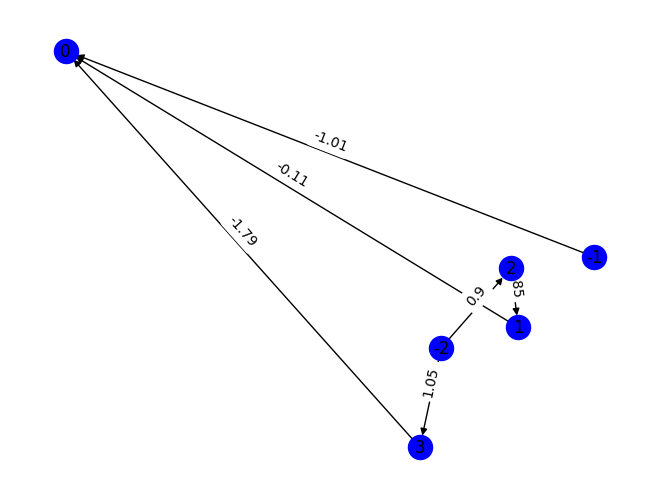

In [59]:
for _ in range(10):
    genom.mutate()
genom.visualize(labels=True)

In [60]:
genom.p_nodes()
genom.p_connections()

===== Input Nodes =====
Key: -2 Type: input Bias: 0
Key: -1 Type: input Bias: 0
===== Hidden Nodes =====
Key: 1 Type: hidden Bias: 0
Key: 2 Type: hidden Bias: 0
Key: 3 Type: hidden Bias: 0
===== Output Nodes =====
Key: 0 Type: out Bias: 0

===== Connections =====
-1 --> 0 Weight: -1.0099088252491608 is active : True
1 --> 0 Weight: -0.10901520094211103 is active : True
-2 --> 2 Weight: 0.8978873081482635 is active : True
2 --> 1 Weight: 0.8481876068063174 is active : True
-2 --> 3 Weight: 1.0454396995865693 is active : True
3 --> 0 Weight: -1.7887044943750967 is active : True



In [61]:
genom.forward([1,1])

[(0, -2.9629149718757066)]

In [62]:
def same_connection(con1,con2):
        return con1.in_Node.key == con2.in_Node.key and con1.out_Node.key == con2.out_Node.key

def contains_connection(con,l_cons):
    for c in l_cons:
        if same_connection(c,con):
            return True
        
    return False

In [63]:
def crossover(genom1,genom2):

        con1 = genom1.connections
        con2 = genom2.connections

        fit1 = np.random.rand(1)
        fit2 = np.random.rand(1)


        new_con = []
        for c1 in con1:
            for c2 in con2:
                if same_connection(c1,c2):
                    if c1.is_active == c2.is_active:
                        if np.random.rand(1) < 0.5:
                            new_con.append(c1)
                        else:
                            new_con.append(c2)
                        break
                    elif fit1 >= fit2:
                        new_con.append(c1)
                    else:
                        new_con.append(c2)

        if fit1 >= fit2:
            for c1 in con1:
                if not contains_connection(c1, new_con):
                    new_con.append(c1)
        else:
            for c2 in con2:
                if not contains_connection(c2, new_con):
                    new_con.append(c2)

        g = Genom(2,1)
        #g.create(genom1.in_Nodes,genom1.out_Nodes,genom1.hidden_Nodes,new_con)
        g.in_Nodes = genom1.in_Nodes
        g.out_Nodes = genom1.out_Nodes
        g.hidden_Nodes = genom1.hidden_Nodes if fit1 > fit2 else genom2.hidden_Nodes
        g.connections = new_con
        g.visualize()

        return g

In [64]:
genom1 = Genom(2,1)
genom2 = Genom(2,1)

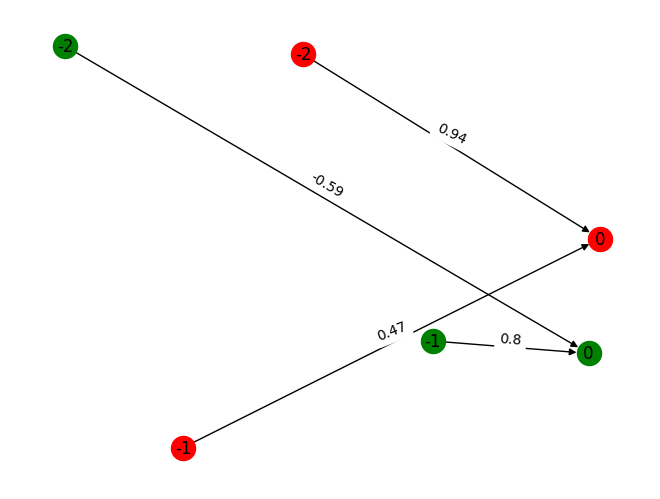

In [65]:
genom1.visualize(color="red")
genom2.visualize(color="green")

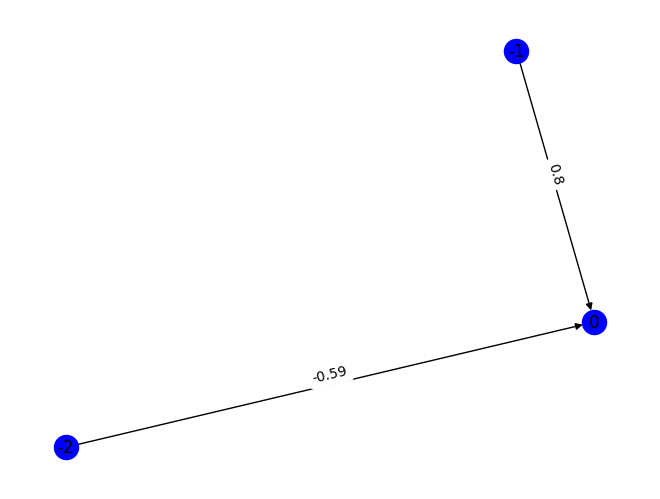

In [66]:
crossover(genom1,genom2)

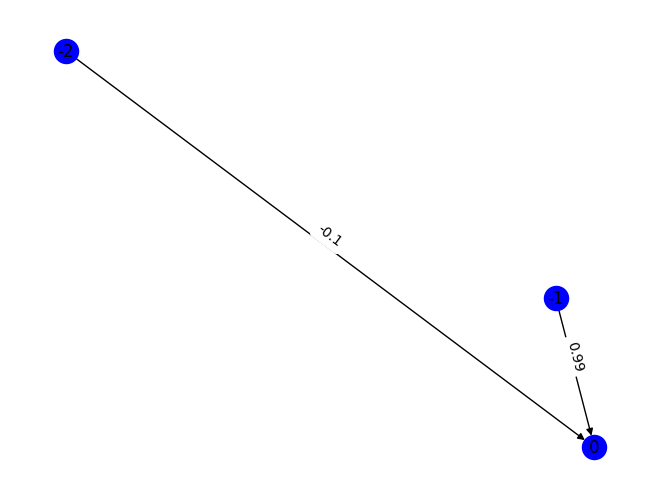

In [67]:
for _ in range(10):
    genom2.mutate()

genom2.visualize()

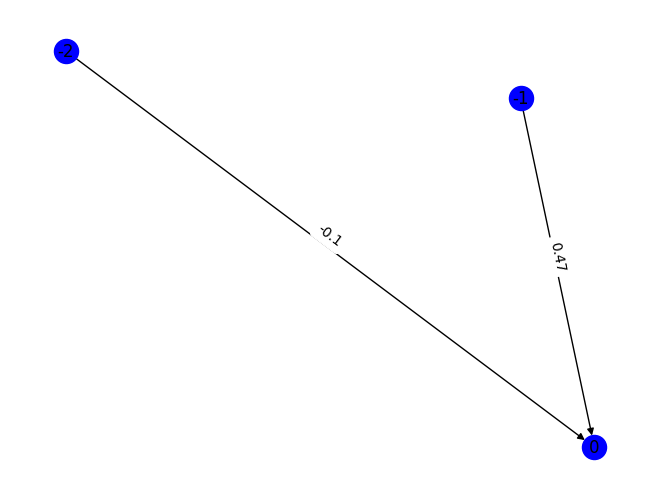

In [68]:
g = crossover(genom1,genom2)

In [69]:
g.forward([0,1])
g.p_connections()

===== Connections =====
-2 --> 0 Weight: -0.09864570723497958 is active : True
-1 --> 0 Weight: 0.4743840324206626 is active : True



In [70]:
class NN():

    def __init__(self, popSize = 2, n_In = 2, n_Out = 1) -> None:
        self.population = [(Genom(n_In,n_Out),0) for _ in range(popSize)] 
        self.popSize = popSize

    def forwardpass(self, index,x):
        return self.population[index][0].forward(x)

    def mutate(self,pop):
        for p in pop:
            p[0].mutate()

    def same_connection(self,con1,con2):
        return con1.in_Node.key == con2.in_Node.key and con1.out_Node.key == con2.out_Node.key

    def contains_connection(self,con,l_cons):
        for c in l_cons:
            if self.same_connection(c,con):
                return True
            
        return False
    
    def cross(self, genom1, genom2, fit1, fit2):

        con1 = genom1.connections
        con2 = genom2.connections


        new_con = []
        for c1 in con1:
            for c2 in con2:
                if self.same_connection(c1,c2):
                    if c1.is_active == c2.is_active:
                        if np.random.rand(1) < 0.5:
                            new_con.append(c1)
                        else:
                            new_con.append(c2)
                        break
                    elif fit1 >= fit2:
                        new_con.append(c1)
                    else:
                        new_con.append(c2)

        if fit1 >= fit2:
            for c1 in con1:
                if not self.contains_connection(c1, new_con):
                    new_con.append(c1)
        else:
            for c2 in con2:
                if not self.contains_connection(c2, new_con):
                    new_con.append(c2)

        g = Genom(2,1)
        g.in_Nodes = genom1.in_Nodes
        g.out_Nodes = genom1.out_Nodes
        hidden_Nodes = []
        hidden_keys = []
        for c in new_con:
            if not c.in_Node.key in hidden_keys and c.in_Node.type == "hidden":
                hidden_keys.append(c.in_Node.key)
                hidden_Nodes.append(Node(c.in_Node.key))
            if not c.out_Node.key in hidden_keys and c.out_Node.type == "hidden":
                hidden_keys.append(c.out_Node.key)
                hidden_Nodes.append(Node(c.out_Node.key))

        g.hidden_Nodes = hidden_Nodes
        g.connections = new_con
        g.n_nodes = len(g.out_Nodes) + len(g.hidden_Nodes)
        #g.visualize()

        return g

    
    def crossover(self):
        idx = [i for i in range(len(self.population))]
        np.random.shuffle(idx)

        child_pop = []

        for i in range(0,len(idx),2):
            child_pop.append((self.cross(self.population[i][0],self.population[i+1][0],self.population[i][1],self.population[i+1][1]),0))
        return child_pop

    def selection(self):
        sortedPop = sorted(self.population, key=operator.itemgetter(1), reverse=True)
        self.population = sortedPop[:self.popSize]

    def fitness(self):
        for i in range(len(self.population)):
            tmp = 0

            if np.round(self.population[i][0].forward([0,0])[0][1]) == 0:
                tmp += 0.25
            if np.round(self.population[i][0].forward([0,1])[0][1]) == 1:
                tmp += 0.25
            if np.round(self.population[i][0].forward([1,0])[0][1]) == 1:
                tmp += 0.25
            if np.round(self.population[i][0].forward([1,1])[0][1]) == 0:
                tmp += 0.25
            #print(genom.forward([0,0]))

            t = list(self.population[i])
            t[1] = tmp
            self.population[i] = tuple(t)

            
    
    def train(self, epochs = 100):
        i = 0
        while True:
            i+=1
            print("Epoch: " + str(i), end=" ")
            print("Acc: " +str(self.population[0][1]))

            if(self.population[0][1] == 1):
               return self.population[0][0]
            '''for p in self.population:
                p[0].p_nodes()
                p[0].p_connections()'''

            child_pop = self.crossover()
            self.mutate(child_pop)
            self.population += child_pop

            self.fitness()
            self.selection()

        return self.population[0][0]


            
            
            
            

In [71]:
nn = NN(popSize=100)
g = nn.train()
g.visualize()


NameError: name 'i' is not defined

In [ ]:
print(g.forward([0,0]))
print(g.forward([0,1]))
print(g.forward([1,0]))
print(g.forward([1,1]))

[(0, -0.0)]
[(0, 0.7437636166967043)]
[(0, -0.2970053271485389)]
[(0, 0.4467582895481654)]
